In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


NUM_SEEDS = 1

plt.rc("text", usetex=True)
plt.rc("font", family="serif")


def plot_cost_function(method_names, cost_lists, time_lists, matrixName):
    data = []
    data_mean = []

    assert len(method_names) * NUM_SEEDS == len(cost_lists) == len(time_lists)
    for i, method in enumerate(method_names):
        minLenCost = min([len(cost_lists[j * 4 + i]) for j in range(NUM_SEEDS)])
        minLenTime = min([len(time_lists[j * 4 + i]) for j in range(NUM_SEEDS)])
        cost_mean = np.zeros(minLenCost)
        time_mean = np.zeros(minLenTime)
        for j in range(NUM_SEEDS):
            costs = cost_lists[j * 4 + i]
            times = time_lists[j * 4 + i]
            assert len(costs) == len(times)
            cost_mean += np.array(costs[:minLenCost])
            time_mean += np.array(times[:minLenTime])
            for iteration, (cost, time) in enumerate(zip(costs, times), start=1):
                data.append([method, iteration, cost, time])
        cost_mean /= NUM_SEEDS
        time_mean /= NUM_SEEDS
        for iteration, (cost, time) in enumerate(zip(cost_mean, time_mean), start=1):
            data_mean.append([method, iteration, cost, time])

    palette = {
        "FR": plt.cm.tab10(0),
        "CN-FR": plt.cm.tab10(0),
        "L-BFGS": plt.cm.tab10(1),
        "CN-L-BFGS": plt.cm.tab10(1),
    }
    markers = {"FR": "X", "L-BFGS": "X", "CN-FR": "o", "CN-L-BFGS": "o"}
    dashes = {"FR": (5, 2), "L-BFGS": (5, 2), "CN-FR": (1, 0), "CN-L-BFGS": (1, 0)}

    df = pd.DataFrame(data, columns=["Method", "Iteration", "Cost", "Time"])
    df_mean = pd.DataFrame(data_mean, columns=["Method", "Iteration", "Cost", "Time"])

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="darkgrid")

    print(df["Method"].unique())

    sns.scatterplot(
        data=df[df["Iteration"] % 10 == 0],
        x="Time",
        y="Cost",
        hue="Method",
        style="Method",
        palette=palette,
        markers=markers,
        alpha=0.2,
        legend=False,
    )

    sns.lineplot(
        data=df_mean,
        x="Time",
        y="Cost",
        hue="Method",
        style="Method",
        palette=palette,
        dashes=dashes,
        linewidth=2,
    )

    minData = df_mean["Cost"].min()
    maxData = df_mean["Cost"][df_mean["Method"] == "CN-L-BFGS"].max()
    assert maxData > minData

    plt.xlabel("Time (seconds)", fontsize=20)
    plt.ylabel("$f(X)$", fontsize=20)
    plt.ylim(minData - (maxData - minData) * 0.1, maxData + (maxData - minData) * 1.1)
    plt.legend(loc="upper right", prop=dict(family="serif", size=20))
    plt.tight_layout()
    plt.savefig(f"plot/{matrixName}.pdf", bbox_inches="tight")
    plt.show()

In [13]:
def parse_hist_file(file_path):

    data = {}
    with open(file_path, "r") as file:
        num_matrices, num_methods = map(int, file.readline().strip().split())

        for _ in range(num_matrices):
            matrix_name = file.readline().strip()
            data[matrix_name] = {}

            for _ in range(num_methods):
                method_name = file.readline().strip()
                data[matrix_name][method_name] = {}
                for idx in range(NUM_SEEDS):
                    data[matrix_name][method_name][idx] = {}
                    _hist_size = int(file.readline().strip())
                    hist = list(map(float, file.readline().strip().split()))
                    data[matrix_name][method_name][idx]["history"] = hist
                    time = list(map(float, file.readline().strip().split()))
                    data[matrix_name][method_name][idx]["time"] = time
                    time_line = file.readline().strip()
                    avg_time = float(time_line.split(": ")[1])
                    data[matrix_name][method_name][idx]["elapsed_time"] = avg_time
                    score_line = file.readline().strip()
                    avg_score = float(score_line.split(": ")[1])
                    data[matrix_name][method_name][idx]["score"] = avg_score

    return data

In [14]:
file_path = "hist.txt"
parsed_data = parse_hist_file(file_path)
print(parsed_data.keys())

dict_keys(['cycle300', 'jagmesh1', 'btree9', '1138_bus', 'dwt_1005', 'dwt_2680'])


cycle300
['FR' 'CN-FR' 'L-BFGS' 'CN-L-BFGS']


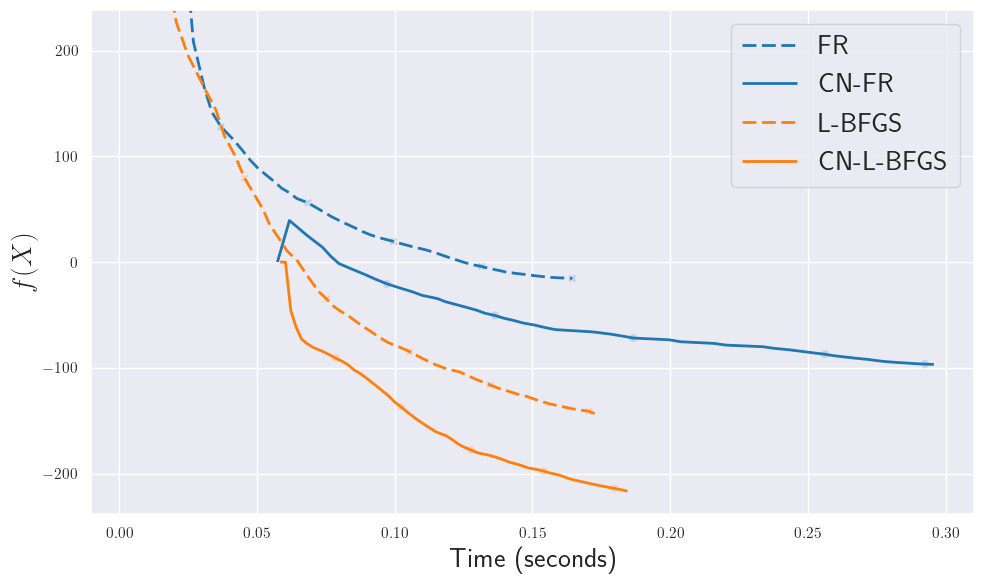

jagmesh1
['FR' 'CN-FR' 'L-BFGS' 'CN-L-BFGS']


KeyboardInterrupt: 

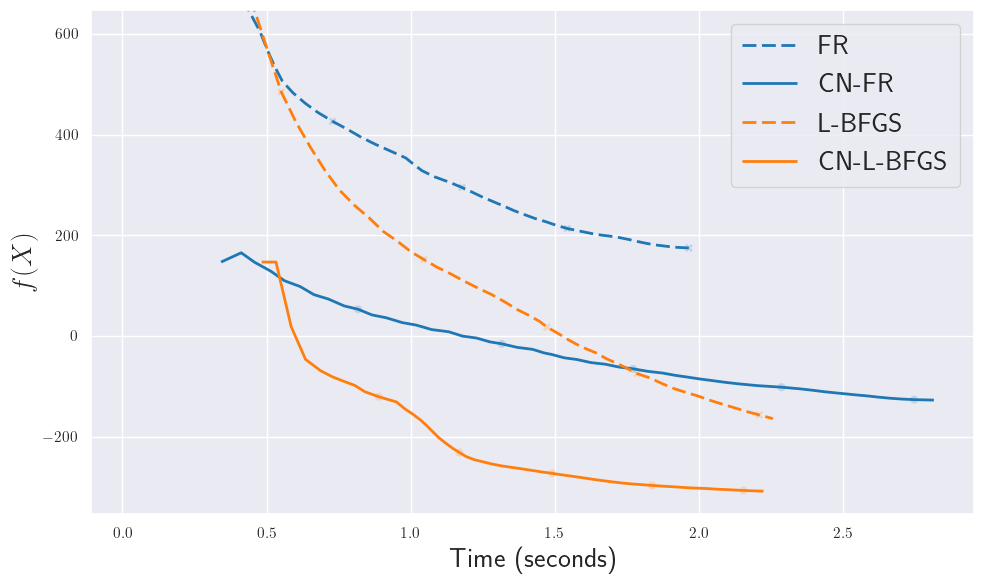

In [15]:
for matrixName in parsed_data:
    print(matrixName)
    methods = parsed_data[matrixName].keys()
    costs = [
        parsed_data[matrixName][method][idx]["history"]
        for idx in range(NUM_SEEDS)
        for method in methods
    ]
    times = [
        parsed_data[matrixName][method][idx]["time"]
        for idx in range(NUM_SEEDS)
        for method in methods
    ]
    plot_cost_function(methods, costs, times, matrixName)

In [1]:
import glob
import networkx as nx
from src.python.vis.visGraph import visGraph


def read_file(file_path):
    with open(file_path, "r") as file:
        n, m, _k = map(float, file.readline().strip().split())
        assert n == int(n) and m == int(m)
        n = int(n)
        m = int(m)
        row = []
        col = []
        data = []
        for _ in range(m):
            r, c, d = map(float, file.readline().strip().split())
            assert r == int(r) and c == int(c)
            r = int(r)
            c = int(c)
            row.append(r)
            col.append(c)
            data.append(d)
        positions_size = int(file.readline().strip())
        positions = []
        for _ in range(positions_size):
            position = []
            for _ in range(n):
                x, y = map(float, file.readline().strip().split())
                position.extend([x, y])
            positions.append(position)

    # print(n, m, f"{m / (n * (n - 1) / 2):.3%}")

    Gs = []
    for pos in positions:
        G = nx.Graph()
        for i in range(n):
            G.add_node(i, pos=(pos[2 * i], pos[2 * i + 1]))
        for i in range(m):
            G.add_edge(row[i], col[i], weight=data[i])
        Gs.append(G)

    return Gs


paths = glob.glob("out/*.out")
paths.sort()
for file_path in paths:
    if "jagmesh1" not in file_path:
        continue
    print(file_path)
    Gs = read_file(file_path)
    idx = (
        100
        if any(name in file_path for name in ["jagmesh1", "dwt_1005", "btree9"])
        else 150
    )
    G = Gs[min(idx, len(Gs) - 1)]
    extension = ".png"
    visGraph(
        G,
        nx.get_node_attributes(G, "pos"),
        savePath="vis/" + file_path.split("/")[-1].replace(".out", extension),
    )
    if "jagmesh1" in file_path:
        visGraph(
            Gs[50],
            nx.get_node_attributes(Gs[50], "pos"),
            savePath="vis/fig1_" + file_path.split("/")[-1].replace(".out", extension),
        )
        if "L-BFGS" in file_path:
            visGraph(
                Gs[0],
                nx.get_node_attributes(Gs[0], "pos"),
                savePath=(
                    "vis/fig1_init_" + ("CN.png" if "CN" in file_path else "random.png")
                ),
            )

out/jagmesh1_CN-FR.out
out/jagmesh1_CN-L-BFGS.out
out/jagmesh1_FR.out
out/jagmesh1_L-BFGS.out
